# Penguin Project
#### Raashi Chaudhari, Christen Tai, Ryan Voda

Can we find the best predictors of the species of a penguin and predict a penguin's species based on just a few data points? In this project, we are going to walk through how to make a program which solves this problem.

Our sample set will be the Palmer Penguins data set, containing Adelie, Chinstrap, and Gentoo penguins.

## Accessing the Data

Before we do anything, import the required python packages.

In [1]:
import pandas as pd
import urllib
import numpy as np
import csv
from matplotlib import pyplot as plt
from sklearn import tree, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression # picked a MODEL CLASS
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from sklearn import metrics

First, let's start to interpret our data by accessing a csv file containing the data. In this case, the Palmer Penguins data set is declared by:

url = "https://philchodrow.github.io/PIC16A/datasets/palmer_penguins.csv"

and we read this csv file and declare it as a dataframe.

In [2]:
url = "https://philchodrow.github.io/PIC16A/datasets/palmer_penguins.csv"
filedata = urllib.request.urlopen(url)
to_write = filedata.read()

try:
    with open("palmer_penguins.csv", "wb") as f:
        f.write(to_write)
    penguins = pd.read_csv('palmer_penguins.csv') # read csv file, save it as a data frame
except csv.Error:
    print("Not a csv")

## Data Exploration

Now that we have converted our data to a pandas dataframe, we can read the beginning of it:

In [3]:
penguins.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,11/11/07,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,11/11/07,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,11/16/07,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,11/16/07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,11/16/07,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN


We now separate the species by declaring them based on their names in the "Species" column:

In [4]:
Adel = penguins[penguins["Species"] == "Adelie Penguin (Pygoscelis adeliae)"]
Gen = penguins[penguins["Species"] == "Gentoo Penguin (Pygoscelis papua)"]
Chin = penguins[penguins["Species"] == "Chinstrap Penguin (Pygoscelis antarctica)"]

For simplicity, we make a new column containing shortened names of penguin species. "Adelie" is much simpler than "Adelie Penguin (Pygoscelis adeliae)".

In [5]:
penguins['Species'] = penguins['Species'].str.split().str.get(0)
penguins.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,11/11/07,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,11/11/07,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,11/16/07,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,PAL0708,4,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,11/16/07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,11/16/07,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN


Now, let's create an array called "species" which contains the types of species in our dataframe, so we know what we're working with:

In [6]:
species = pd.unique(penguins['Species'])
species

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

Observe the mean metrics of each species:

In [7]:
penguins.groupby("Species").mean()

,Sample Number,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo)
Species,,,,,,,
Adelie,76.5,38.791391,18.346358,189.953642,3700.662252,8.859733,-25.804194
Chinstrap,34.5,48.833824,18.420588,195.823529,3733.088235,9.356155,-24.546542
Gentoo,62.5,47.504878,14.982114,217.186992,5076.016260,8.245338,-26.185298


### Discussion:
_____

**Culmen Length (mm):**
- Seems to be a good distinguisher of Adelie from Gentoo/Chinstrap

**Body Mass (g):**
- Seems to be a good distinguisher of Gentoo from Adelie/Chinstrap

### Islands

##### Here are the three possible islands:

In [8]:
island = penguins["Island"].unique()
for x in island:
    print(x)

Torgersen
Biscoe
Dream


##### Frequency of Penguins by Species per Island

Seeing that there are only three possible islands, we will make a figure to evaluate whether the island of a penguin is a qualitative feature we can use to predict species.

First, we will make a figure which shows the frequency of a penguin species on each island.

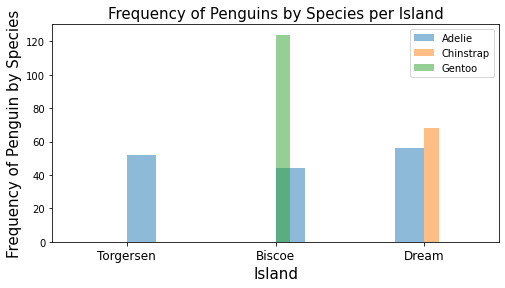

In [9]:
fig, ax = plt.subplots(1, figsize= (8, 4))
# for penguin in species:

# penguins["Species"] = penguins["Species"].str.split().str.get(0) # changes scientific name of penguin to one-word species
penguins["ShortName"] = penguins["Species"].str.split().str.get(0)
def plot_hist(df): 
    ax.hist(df['Island'], label = df['Species'].iloc[0], alpha = 0.5) # makes hist with 
    plt.xticks(label = df['Island'])
    
#     ax.set(label = str(species[0]).split()[0])

penguins.groupby('Species').apply(plot_hist)
plt.title(label = 'Frequency of Penguins by Species per Island', fontsize = 15)
plt.xticks(fontsize = 12)
plt.xlabel(xlabel = 'Island', fontsize = 15)
plt.ylabel(ylabel = 'Frequency of Penguin by Species', fontsize = 15)
plt.xlim(-0.5, 2.5)
ax.legend()

From the figure, we can observe that the qualitative feature of a penguin's island is useful in deducing a penguin's species.

### Discussion:
_______

**Adelie:**

Seem to live everywhere, on all islands!

**Chinstrap:**

Live only on Dream Island!

**Gentoo:**

Live only on Biscoe Island!

Now, we can use this qualitative data in terms of numbers. We'll set each island to a number, and add a column "Island_num":

In [10]:
# Makes categorical data (i.e. islands) into numbers
le = preprocessing.LabelEncoder() # makes an instance of labelencoder
X = le.fit_transform(penguins["Island"]) 
penguins["Island_num"] = le.fit_transform(penguins["Island"]) # actually sets the #s to each island

penguins.head()

# Dream = 1
# Torgenson = 2
# Biscoe = 3

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments,ShortName,Island_num
0,PAL0708,1,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,11/11/07,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.,Adelie,2
1,PAL0708,2,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,11/11/07,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN,Adelie,2
2,PAL0708,3,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,11/16/07,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN,Adelie,2
3,PAL0708,4,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,11/16/07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.,Adelie,2
4,PAL0708,5,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,11/16/07,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN,Adelie,2


We have successfully incorporated the qualitative feature "Island" of a species into our dataframe in terms of numbers under our new column "Island_num".

Secondly, we will find two quantitative features of our dataframe. In this case, let's access the columns 'Culmen Length (mm)' and 'Body Mass (g)'.

In [11]:
penguins[['Culmen Length (mm)', 'Body Mass (g)']]

,Culmen Length (mm),Body Mass (g)
0,39.1,3750.0
1,39.5,3800.0
2,40.3,3250.0
3,NaN,NaN
4,36.7,3450.0
...,...,...
339,NaN,NaN
340,46.8,4850.0
341,50.4,5750.0
342,45.2,5200.0


Okay, let's get rid of NaN values which won't help us make an accurate prediction:

In [12]:
X = penguins[["Culmen Length (mm)", "Body Mass (g)"]].dropna()
X

,Culmen Length (mm),Body Mass (g)
0,39.1,3750.0
1,39.5,3800.0
2,40.3,3250.0
4,36.7,3450.0
5,39.3,3650.0
...,...,...
338,47.2,4925.0
340,46.8,4850.0
341,50.4,5750.0
342,45.2,5200.0


We will now create a scatterplot which compares culmen length and body mass of penguins labeled by species.
Then, we will hopefully observe a relationship between species and culmen length and body mass:

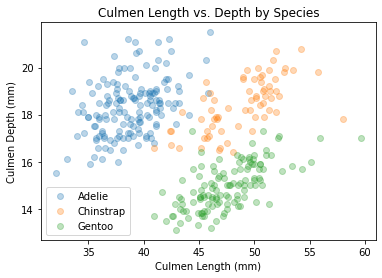

In [13]:
species = penguins["ShortName"].unique()

fig, ax = plt.subplots(1)
ax.set(xlabel = "Culmen Length (mm)", ylabel = "Culmen Depth (mm)", title = "Culmen Length vs. Depth by Species")


for specie in species:
    new = penguins[penguins["Species"] == specie]
    x = new["Culmen Length (mm)"]
    y = new["Culmen Depth (mm)"]
    ax.scatter(x, y, alpha = 0.3, label = specie)
    ax.legend()

Observing the scatterplot, we can deduce that there is a strong relationship between a penguin's species and its culmen length, depth.

- Adelie penguins tend to have lower culmen length, higher culmen depth.

- Chinstrap penguins tend to have higher culmen length, higher culmen depth.

- Gentoo penguins tend to have higher culmen length, lower culmen depth.

## Building Models:

At this point, we have isolated:

- One qualitative feature: `"Island"`

- Two quantitative features: `"Culmen Length (mm)"`, `"Body Mass (g)"`

These features serve as good predictors of a penguin's species. Now, we will build three predictive models, and observe how each one performs.

First, we will create a class. It will read the csv file as a df, use the variables we decided on, and make `X_train`, `y_train`, `X_test`, and `y_test` to use for creation of models later.

We had to ensure that the class could clean data that has species data ("complete," pre-existing data) as well as penguin data that does not have information about species. This was handled with `if`/`else` statements.

#### Class:

In [14]:
class penguinData():
    """ 
    Reads in csv file of penguin data and cleans up for Species Prediction 
    by functions logisticRegression() or randomForestClassifier()
    """
    
    def __init__(self, csv): #, X_train = pd.DataFrame(), X_test = pd.DataFrame(), y_train = pd.DataFrame(), y_test = pd.DataFrame()): # Takes in and reads csv file
        """
        Initialize class with user-supplied csv file
        Args:
            csv: a .csv file
        Returns: 
            None
        """
        self.csv = csv # instantiate the csv
        self.df = pd.read_csv(csv) # instantiate the df which reads in the csv file
        
    def readData(self): # Method that reads the data; pass in self, which contains the read csv file from the init method
        """
        Prints a readout of the data read
        """
        
        print(self.df) # instantiate using self.___
    
    def dropNAN(self):
        """
        Drops any data that will not be used (i.e. drops unused columns or NAN values)
        """
        
        try: # only for training data, like palmer_penguins.csv, which contain Species data
            self.variables = self.df[['Culmen Length (mm)', 'Body Mass (g)', 'Island', 'Species']] # data on penguins with Species
        
        except KeyError: # for the actual dataset which does not contain Species data
            self.variables = self.df[['Culmen Length (mm)', 'Body Mass (g)', 'Island']] # data on penguins without Species
            
        self.df = self.variables.dropna(axis = 0)

    def islandToNum(self): 
        """
        Changes categorical island data to numbers.
        """
        
        self.le = preprocessing.LabelEncoder() # makes an instance of labelencoder
        self.X = self.le.fit_transform(self.df['Island']) 
        self.df['Island_num'] = self.le.fit_transform(self.df["Island"]) # actually sets the #s to each island
    
    def splitTrainTest(self):
        """
        Splits the penguin data into X (predictor variables) and y (target variables). 
        If the data is training data (i.e. palmer_penguins.csv), generates X_train, X_test, y_train, and y_test groups;
        if the data is actual data (i.e. penguin data without Species), only creates dataframe of X (predictor variables)
        """
        
        self.dropNAN() # member function call to drop NAN values
        self.islandToNum() # member function call to turn island categories into numbers
    
        self.X = self.df[['Culmen Length (mm)', 'Body Mass (g)', 'Island_num']] # sets predictor variables
        
        if 'Species' in self.df: # for "complete" data that contains true Species (e.g. palmer_penguins.csv)
            self.y = self.df['Species'] # this sets the target variables
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size = 0.2, random_state = 2022) # creates instance variables of X/y, train/test
#         print(self.X_train, self.X_test, self.y_train, self.y_test)

The code below takes in a csv file of our data (In this case, palmer_penguins.csv), and puts the csv into the class.

We are also making sure that the csv is useable.

In [15]:
csv = 'palmer_penguins.csv'
penguinData(csv)

try:
    with open(csv, "wb") as f:
        f.write(to_write)
    penguins = pd.read_csv('palmer_penguins.csv') # read csv file, save it as a data frame
except csv.Error as error:
    raise ValueError("Not a csv")
    
try:
    df = pd.read_csv(csv)
except FileNotFoundError:
    print("File not found")
except pd.errors.EmptyDataError:
    print("No data")
except pd.errors.ParserError:
    print("Parse error")
except Exception:
    print("Some other exception")
    
# Second exception handling comes from:
# https://stackoverflow.com/questions/64302419/what-are-all-of-the-exceptions-that-pandas-read-csv-throw

Now, we can predict penguin species based on a few models.

These functions will use pre-existing, "complete" penguin data that has information on both the predictive variables 

`"Island"`, `"Culmen Length (mm)"`, `"Body Mass (g)"` 

as well as the target variables 

`"Species"` 

as data for training. 

This set was called `training` in Model 1 and 2, and was split into `X_train`, `y_train`, `X_test`, and `y_test` groups.

**makeFakeData**

Although all our data for the entire project is from palmer_penguins.csv, we wanted to be able to simulate having "real" data about penguins whose species have not yet been identified. 

To obtain realisitic data, we made a function that randomly takes 100 penguin data from palmer_penguins.csv, only containing

* Culmen Length (mm)
* Body Mass (g)
* Island

and excludes Species data.

We will use this `fake_data.csv` to make species prediction on using our custom functions. 

In [16]:
data = 'palmer_penguins.csv'

def makeFakeData(csv):
    whole = pd.read_csv(csv)
    fake = whole.sample(n = 100)
    fake = fake[['Culmen Length (mm)', 'Body Mass (g)', 'Island']]
    return fake.to_csv('fake_data.csv')

makeFakeData(data)

### Model 1:

#### Logistic Regression

In [17]:
def logisticRegression(csv): 
    """
    Uses existing, complete penguin data (palmer_penguins.csv) as training dataset to predict the species of penguin on
    actual penguin dataset without species information using Logistic Regression model.
    Args: 
        csv: a .csv file
    Returns:
        Prints the train and test scores using Logistic Regression on existing, complete penguin data.
        Returns a new .csv file with species predictions appended to data from original csv .
    """
    
    training = penguinData('palmer_penguins.csv') # instantiate an object of class penguinData (class we just made)
    training.dropNAN()
    training.islandToNum()
    training.splitTrainTest() # call method splitTrainTest() on the object penguins
    
    actual = penguinData(csv) # csv file without Species in it (don't know the species but collected penguin data)
    actual.dropNAN()
    actual.islandToNum()
    actual.splitTrainTest()
    
    LR = LogisticRegression(max_iter = 500) # max_iter default usually 100, but our data is "too big"
    LR.fit(training.X_train, training.y_train) # for every review, LR will output a "probability" of the review being positive
    
    LR_train_score = LR.score(training.X_train, training.y_train) # score the training set
    LR_test_score = LR.score(training.X_test, training.y_test) # score the test set
#     # visually compare to see if there is overfitting
    
    speciesPrediction = LR.predict(actual.X) # makes species predictions using logistic regression
    
    actual.df['Species Prediction'] = speciesPrediction # adds column to dataframe with species predictions

    print("Trained Score:", LR_train_score, "\nTest Score:", LR_test_score) # prints trained vs test score
    
    return actual.df.to_csv('Predicted_Species_Logistic_Regression.csv') # returns a csv of all data plus the species predictions

In [18]:
logisticRegression('fake_data.csv')

Trained Score: 0.9816849816849816 
Test Score: 0.9420289855072463


/var/folders/78/2bv40vms77nf2gnw379jx2rc0000gn/T/ipykernel_4287/2170495507.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Island_num'] = self.le.fit_transform(self.df["Island"]) # actually sets the #s to each island


### Model 2:

#### Random Forest Classification

In [19]:
def randomForestClassifier(csv):
    """
    Uses existing, complete penguin data (palmer_penguins.csv) as training dataset to predict the species of penguin on
    actual penguin dataset without species information using Random Forest Classifier model.
    Args: 
        csv: a .csv file
    Returns:
        Prints the train and test scores using Random Forest Classifier on existing, complete penguin data.
        Returns a new .csv file with species predictions appended to data from original csv .
    """
    
    training = penguinData('palmer_penguins.csv') # instantiate an object of class penguinData (class we just made)
    training.dropNAN()
    training.islandToNum()
    training.splitTrainTest() # call method splitTrainTest() on the object penguins
    
    actual = penguinData(csv)
    actual.dropNAN()
    actual.islandToNum()
    actual.splitTrainTest()
    
    clf = RandomForestClassifier(max_depth=2, random_state=0)
    clf.fit(training.X_train, training.y_train)
    
    rfc_train_score = clf.score(training.X_train, training.y_train)
    rfc_test_score = clf.score(training.X_test, training.y_test)
    
    speciesPrediction = clf.predict(actual.X)
    actual.df['Species Prediction'] = speciesPrediction # adds column to dataframe with species predictions
    
    print("Trained Score:", rfc_train_score, "\nTest Score:", rfc_test_score) # prints trained vs test score
    
    return actual.df.to_csv('Predicted_Species_Random_Forest_Classifier.csv')

In [20]:
randomForestClassifier('fake_data.csv')

Trained Score: 0.9743589743589743 
Test Score: 0.9130434782608695


/var/folders/78/2bv40vms77nf2gnw379jx2rc0000gn/T/ipykernel_4287/2170495507.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Island_num'] = self.le.fit_transform(self.df["Island"]) # actually sets the #s to each island


### Model 3:

#### Clustering

Clustering is unsupervised learning, meaning that we do not give the data labels (y).

The algorithm will look for n_clusters (an integer) amount of characteristics and start grouping/clustering the data based on those characteristics.

The penguin scientist must find out what the labels that the algorithm is using is are.

In [21]:
X = penguins[["Culmen Length (mm)", "Body Mass (g)"]].dropna()
kmeans = KMeans(n_clusters = 3)
kmeans.fit(X)
kmeans.score(X)

-29158614.48331931

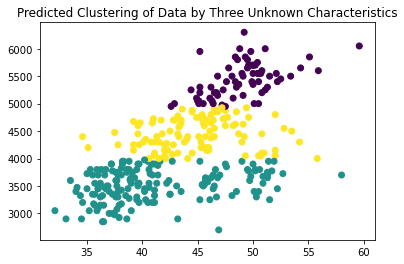

In [22]:
y_kmeans = kmeans.predict(X)
fig, ax = plt.subplots(1)
plt.title('Predicted Clustering of Data by Three Unknown Characteristics')
ax.scatter(X["Culmen Length (mm)"], X["Body Mass (g)"], c = y_kmeans)

Comparing this to our earlier scatterplot (showing culmen length, depth for species), we see that three different clusters are formed using unknown shared characteristics.

The clustering model is trying to find shared characteristics of the data set, but we want to be able to predict a single characteristic (species).

Therefore, the clustering model does not help us predict a penguin's species, so it is not a good model to use.

## Conclusion

Evaluating the performance of our three models, we see:

#### Logistic Regression:

- Trained Score: 0.9853479853479854
- Test Score: 0.9710144927536232

Logistic Regression provides a very good prediction of a penguin's species, as the test score is very high and very close compared to the trained score.

#### Random Forest Classification:

- Trained Score: 0.9633699633699634 
- Test Score: 0.9130434782608695

Random Forest Classification provides a decent prediction, but it doesn't perform as well as Logistic Regression since its test score is a bit lower.

#### Clustering:

As we discussed, clustering is unsupervised learning. Therefore, this model is not suited to our task.

So we can conclude clustering is not as good a model in this case as Logistic Regression and Random Forest Classification.

#### Results

##### Logistic Regression Model gives us:

Trained Score: 0.9816849816849816 

Test Score: 0.9420289855072463

##### while the Random Forest Classification gives us:

Trained Score: 0.9743589743589743 

Test Score: 0.9130434782608695

Since the test score for random fitting is less than the trained score for Random Forest Classification, and the percentages are lower than those of Logistic Regression,

We can conclude that our Logistic Regression Model is best for predicting a penguin's species.